## Vehicle Detection and Tracking
## by Reinaldo Maslim

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

5. Estimate a bounding box for vehicles detected.

## Perform HOG and train SVM classifier
In this step, HOG features are extracted from vehicles and non-vehicles training sets. From here, we split to 80:20 training vs validation set for SVM training. Some parameters for tuning include:

1. colorspace  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
2. orient
3. pix_per_cell
4. cell_per_block 
5. hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


In [1]:
#load important libraries

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:

#load training datasets
car_images = glob.glob('./data/vehicles/**/*.png')
noncar_images = glob.glob('./data/non-vehicles/*.png')
print(len(car_images), len(noncar_images))

#define function to get HOG
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    


8792 8968


...


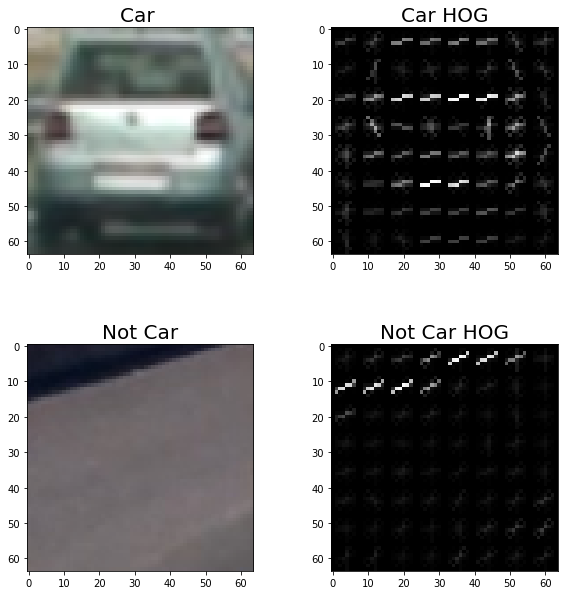

In [3]:
#visualize hog function

car_img = mpimg.imread(car_images[0])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[0])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car ', fontsize=20)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=20)
ax3.imshow(noncar_img)
ax3.set_title('Not Car', fontsize=20)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Not Car HOG', fontsize=20)
print('...')

In [4]:
#define extract features for 64x64 image, only use HOG

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
        #perform similar to flipped image
        feature_image_flip=cv2.flip(feature_image,1)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image_flip.shape[2]):
                hog_features.append(get_hog_features(feature_image_flip[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image_flip[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    # Return list of feature vectors
    return features

In [5]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

75.41 Seconds to extract HOG features...
Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1296


In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.55 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  1.  0.  1.  0.]
0.00206 Seconds to predict 10 labels with SVC


## Implement sliding window

In this section, sliding window method is implemented. Multiple windows configurations are used in window_pyramid function. 

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    bbox = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



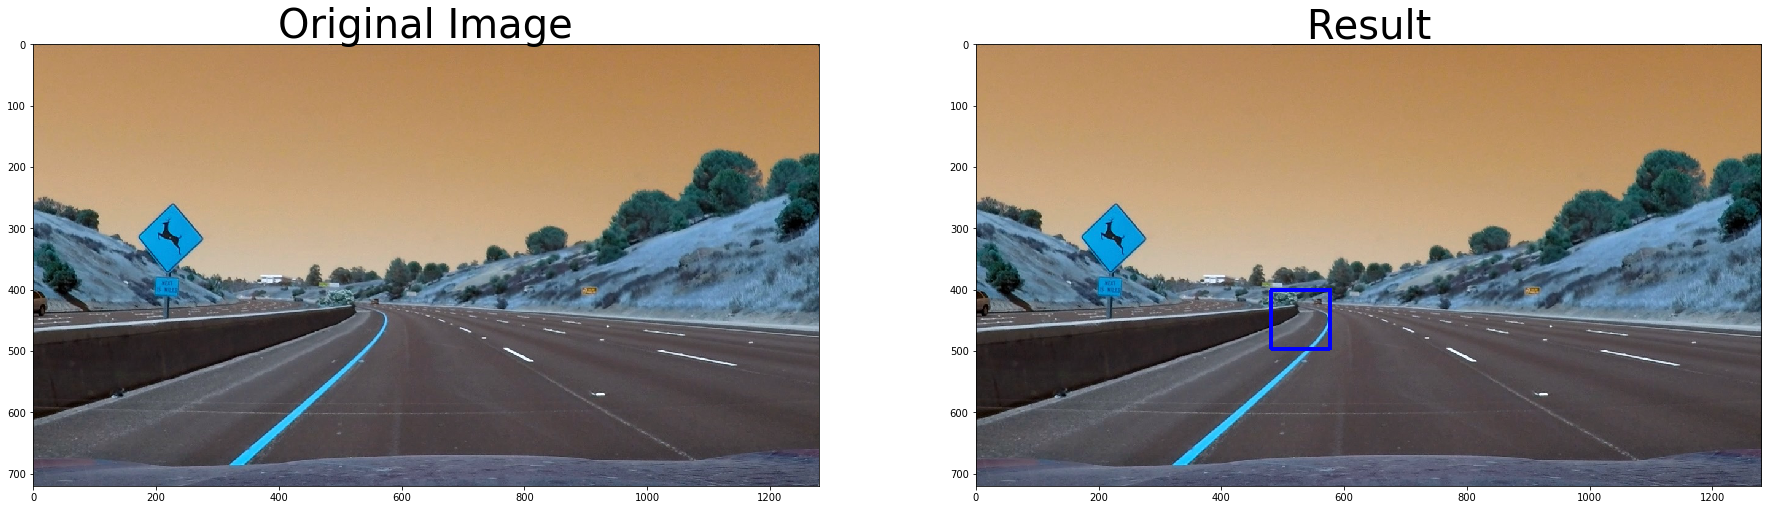

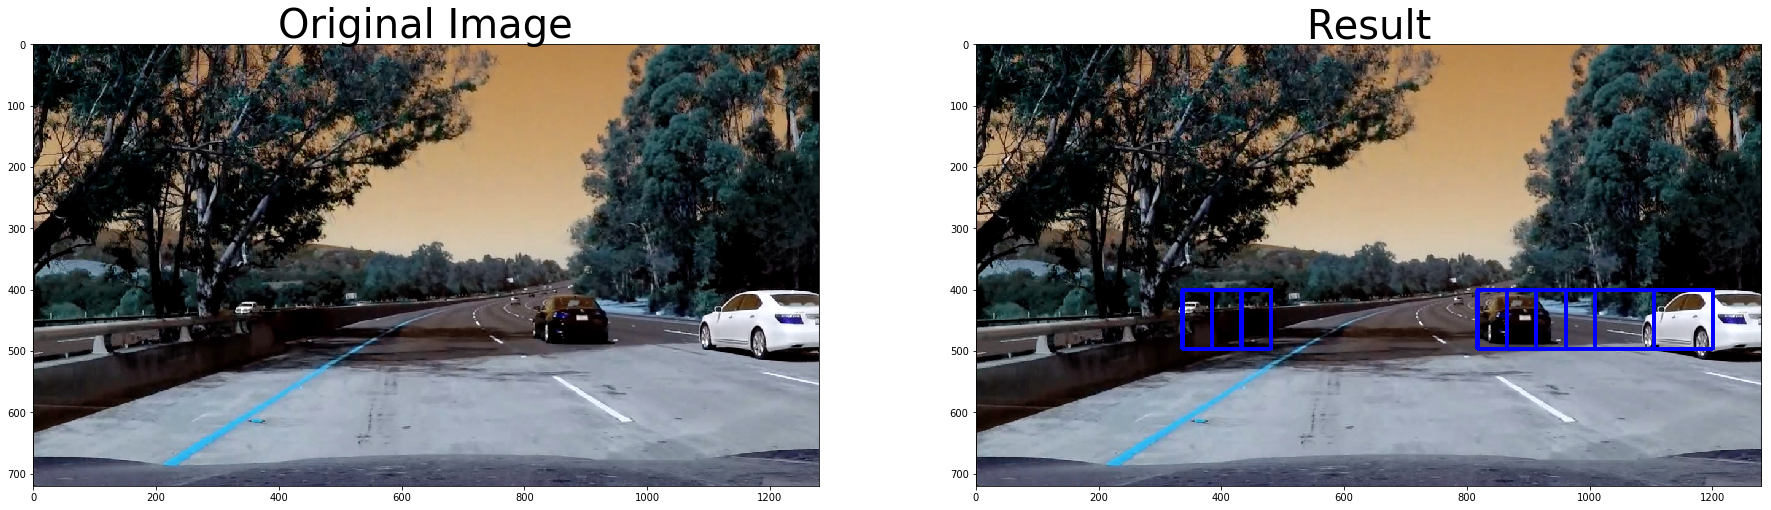

In [8]:
ystart = 400
ystop = 700
scale = 1.5

for i in range(1, 6):
    fname = './test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #print(np.max(image))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    bbox = find_cars(image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    test_img_rects = draw_boxes(image, bbox)    
    ax2.imshow(test_img_rects)
    ax2.set_title('Result', fontsize=40)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


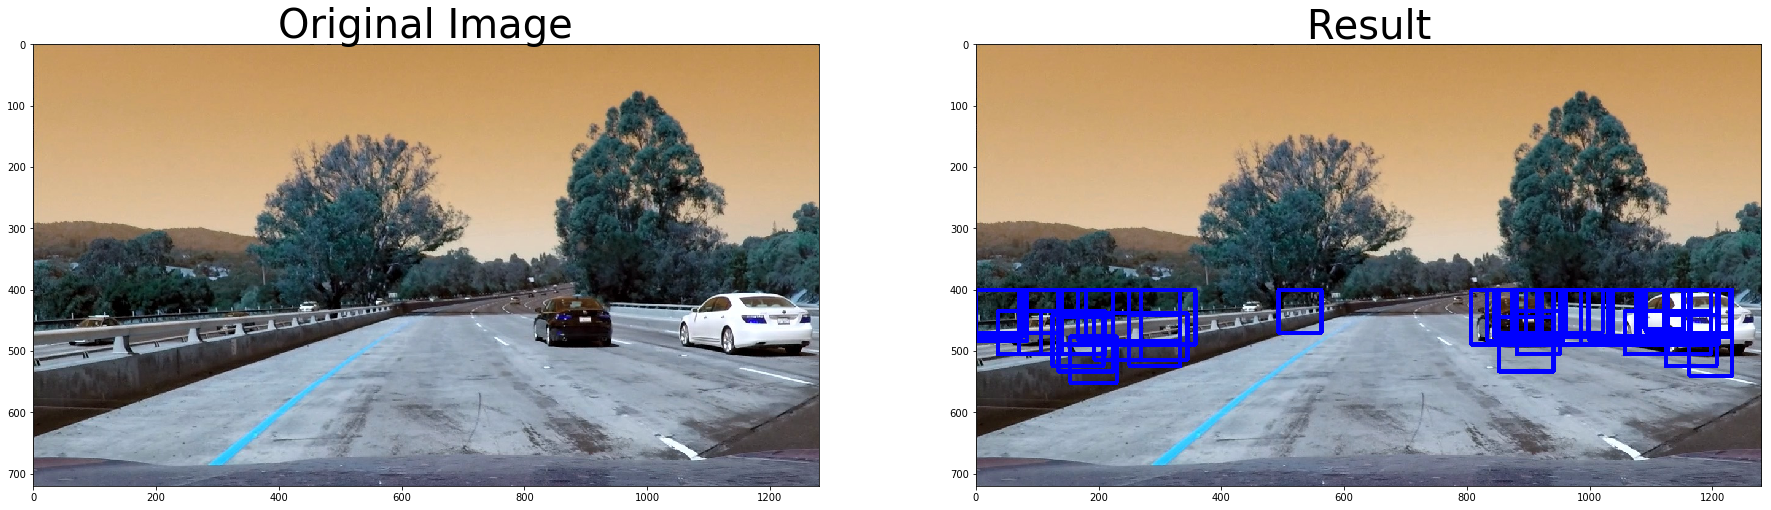

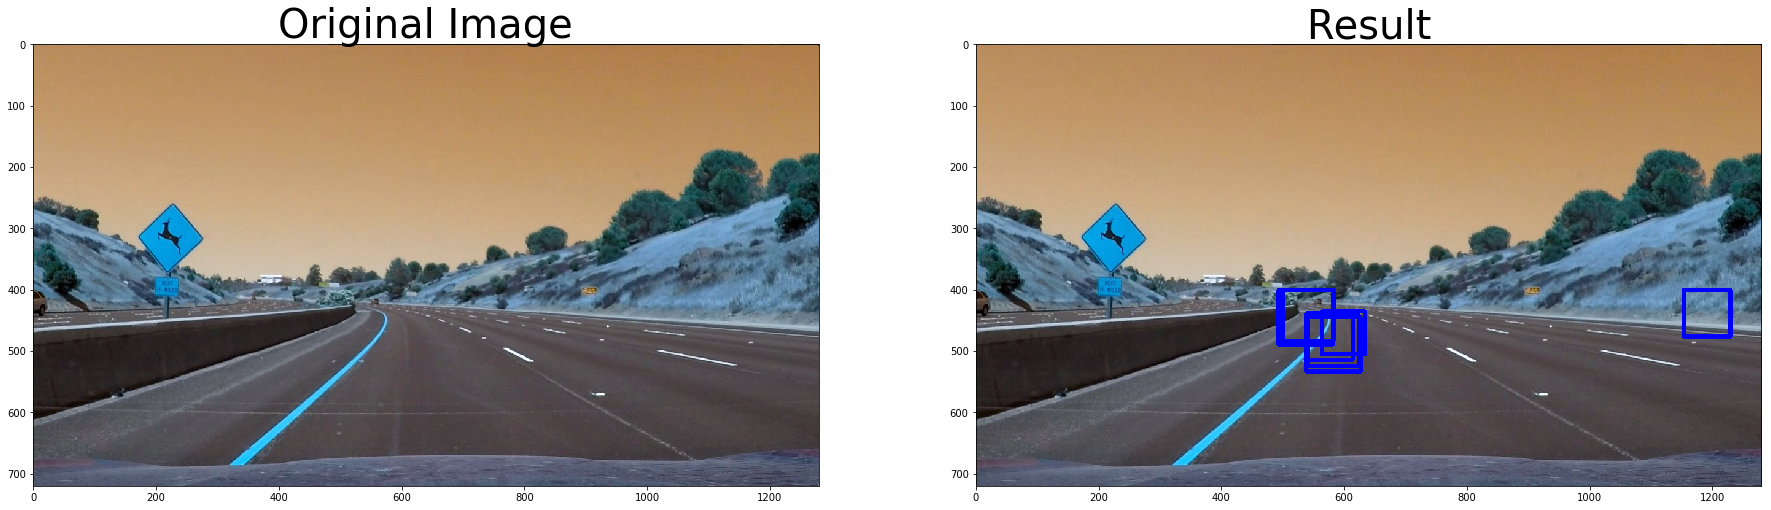

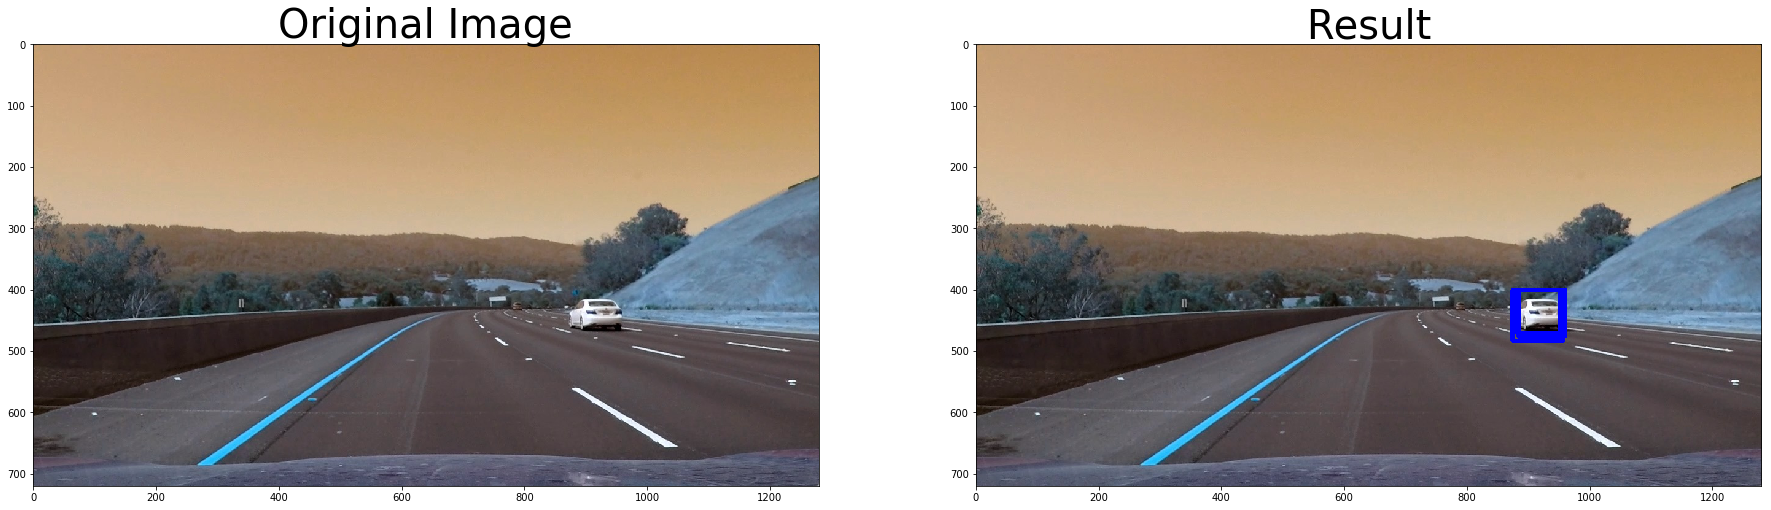

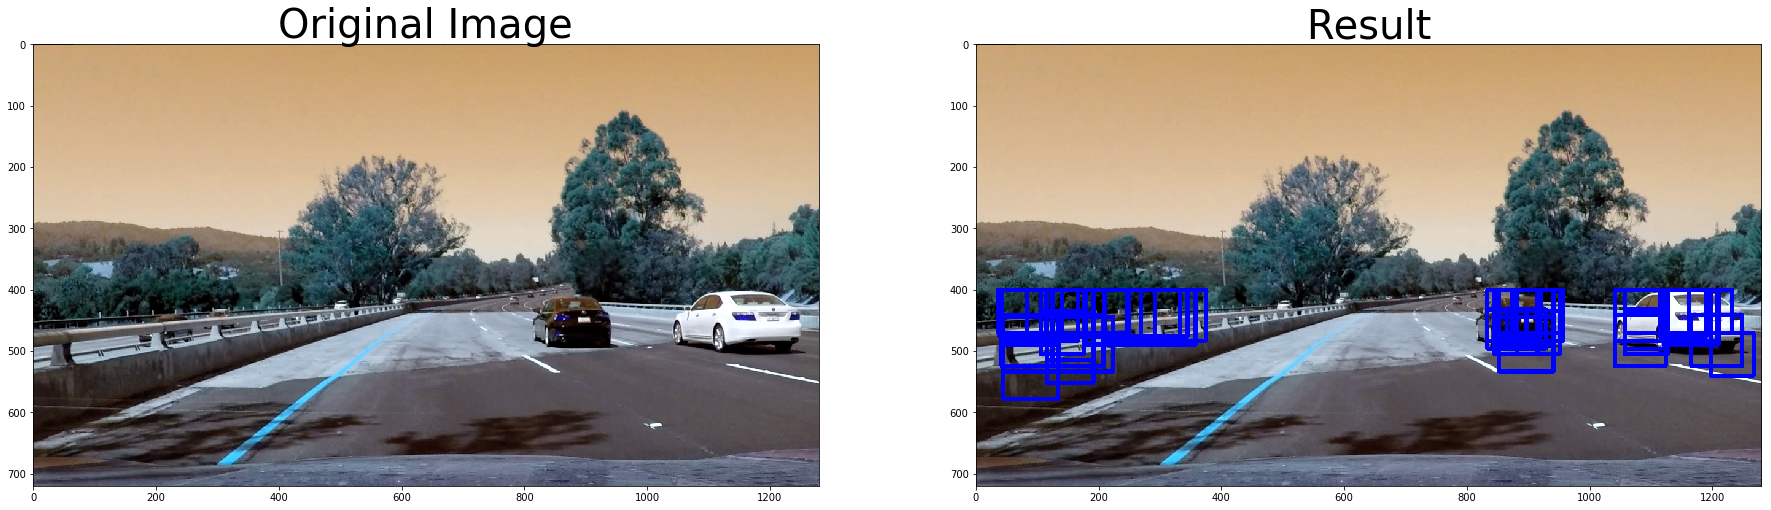

In [9]:
def window_pyramid(image, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):
    
    
    bbox=[]
    for i in range(5):
        ystart=400
        ystop=500+i*50
        if ystop>image.shape[0]:
            ystop=image.shape[0]
        
        
        scale=1+0.1*i
        bbox.extend(find_cars(image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block))
    return bbox

for i in range(1, 6):
    fname = './test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #print(np.max(image))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)
    bbox = window_pyramid(image, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    test_img_rects = draw_boxes(image, bbox)    
    ax2.imshow(test_img_rects)
    ax2.set_title('Result', fontsize=40)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Heat Map to remove false positives
To remove false positives, results from multiple window configurations are combined into a heat map. Then, we apply threshold to the heat map to filter out low confidence detections. By doing so, we can remove false positives in a single frame.


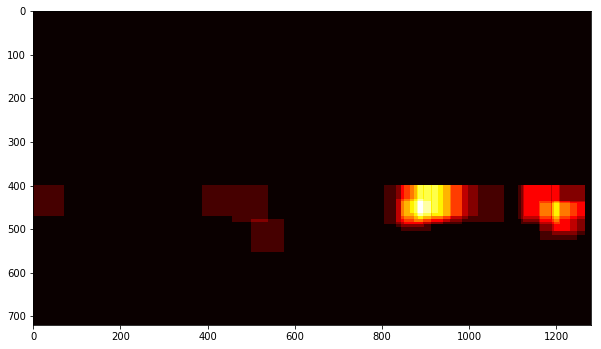

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

heatmap_img = np.zeros_like(image[:,:,0])
heatmap_img = add_heat(heatmap_img, bbox)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


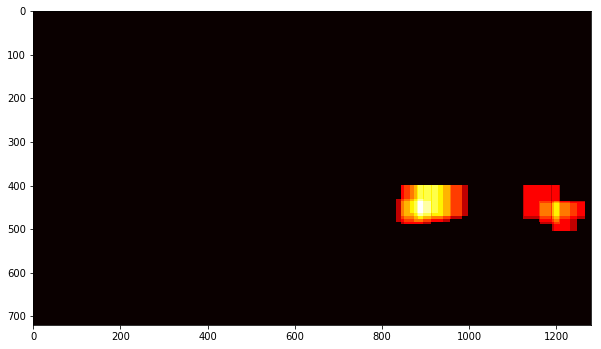

In [12]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


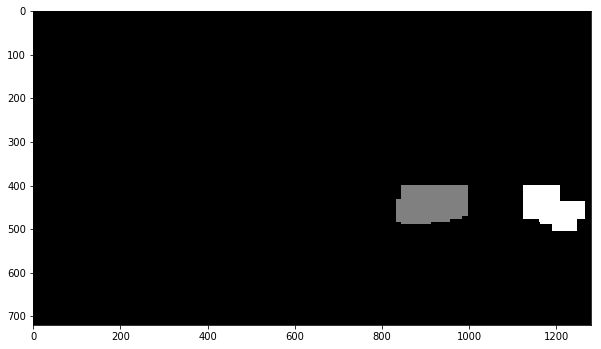

In [13]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

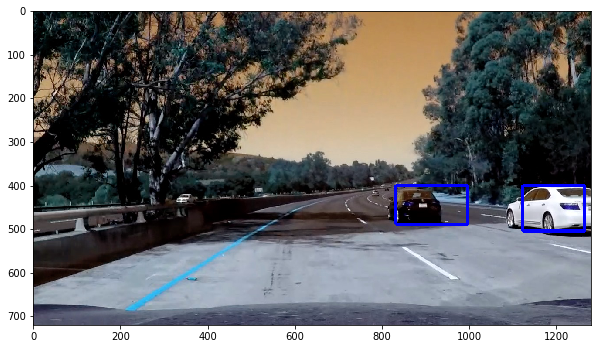

In [15]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [16]:
previous_bbox=[]
n_frames=12
count=0

def pipeline(image):
    global count, n_frames, previous_bbox
    if count==0:
        previous_bbox=[]
    current_bbox=[]
    
    bbox = window_pyramid(image, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block)
    previous_bbox.append(bbox)
    count+=1
    
    for rect in previous_bbox:
        current_bbox.extend(rect)
        if count>5:
            count-=1
            del previous_bbox[0]
    
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, current_bbox)
    heatmap_img = apply_threshold(heatmap_img, 7)
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

## Run on Video
The pipeline is run on project videos for validation.

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
mask_with_poly=False

In [18]:
project_output = './test_video_result.mp4'
#clip1 = VideoFileClip("./test_video.mp4")
#project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
#%time project_clip.write_videofile(project_output, audio=False)

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [20]:
project_output = './project_video_result.mp4'
#clip1 = VideoFileClip("./project_video.mp4")
#project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
#%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./project_video_result.mp4
[MoviePy] Writing video ./project_video_result.mp4


100%|█████████▉| 1260/1261 [09:02<00:00,  2.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result.mp4 

CPU times: user 22min 57s, sys: 2.06 s, total: 22min 59s
Wall time: 9min 3s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [22]:
project_output = './combined_result.mp4'
#clip1 = VideoFileClip("./lane_finding.mp4")
#project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
#%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ./combined_result.mp4
[MoviePy] Writing video ./combined_result.mp4


100%|█████████▉| 1260/1261 [09:25<00:00,  2.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./combined_result.mp4 

CPU times: user 23min 10s, sys: 2.43 s, total: 23min 12s
Wall time: 9min 26s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Discussion
By only using HOG features, it is sufficient to create a satisfactory car detection. For improvement, we can add color histograms and spatial histograms. However, the scaler must be generalised for training set and the real case.Tuning is may be challenging, but most parameters will work. 

To reduce false positives, I combined the heatmaps for subsequent image frames. In this way, we can get higher confidence level. Moreover, more window sizes combinations can be used to give flexibility to car's size. 

Like all vision based detection faces, good lighting conditions is required. Kalman filter can be applied to imply speed of cars by analyzing bounding boxes in a continuous time-frame.